In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, SimpleRNN, MaxPooling1D, Conv1D
from keras.optimizers import RMSprop, Nadam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import backend as K
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  classification_report
import unidecode
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay


np.random.seed(42)
tf.random.set_seed(42)

In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score

def imprimir_metricas(precisao, revocacao, f1, acuracia):
    precisao = precisao * 100
    revocacao = revocacao * 100
    f1 = f1 * 100
    acuracia = acuracia * 100
    print('precisao {:.2f}'.format(precisao))
    print('revocacao {:.2f}'.format(revocacao))
    print('f1-score {:.2f}'.format(f1))
    print('acuracia {:.2f}'.format(acuracia))

def plotarMatrizConfusao(y_val, predicao, nome_classificador, label_encoder, periodo):
    cm = confusion_matrix(y_val,np.around(predicao, decimals=0))
    cm = np.array(cm)
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Normalizar a matriz de confusão para ter percentagens
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Configurar o estilo do seaborn
    sns.set(font_scale=1.2)
    
    # Plotar a matriz de confusão
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=label_encoder.classes_)
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.title(f'Matriz de confusão {nome_classificador} - {periodo}', fontdict={'color':'black', 'weight':'bold'})
    disp.plot(cmap='coolwarm', ax=ax, values_format='.2f', text_kw={'color':'black', 'weight':'bold'})
    ax.grid(False)

    #sns.heatmap(cm, cmap='coolwarm', annot=True,
                #xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_
    #            )
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.savefig(f'matrizes_confusao/matrizConfusao_{unidecode.unidecode(nome_classificador.replace(" ", "_")).lower()}_{periodo}')
    plt.show()
    plt.close()

In [5]:
def model_SimpleRNN():
    model = Sequential()
    model.add(SimpleRNN(units=40))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid'))
    return model
    
def model_LSTM():
    model = Sequential()
    model.add(LSTM(units=300, activation='sigmoid', return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

def model_Bidirectional():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=300, activation='sigmoid', return_sequences=False)))
    model.add(Dense(1, activation='sigmoid'))
    return model

def model_CNN_LSTM():
    model = Sequential()
    
    # Convolutional Layer
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    # LSTM Layer
    model.add(LSTM(units=300, activation='sigmoid', return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [6]:
def plotGraph_models(model):
    history = model.history

    print(history.history.keys())

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)


    plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    y_arrow = max(val_acc)
    x_arrow = val_acc.index(y_arrow) + 1
    plt.annotate(str(y_arrow)[:6],
                (x_arrow, y_arrow),
                xytext=(x_arrow + 5, y_arrow + .02),
                arrowprops=dict(facecolor='orange', shrink=0.05))
    plt.xticks(epochs)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(epochs)
    plt.show()

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
epochs = 20

In [8]:
periodo = 'pre-pandemia'

choq = ['volumeTweets_media', 'volumeTweets_variancia', 'volumeTweets_mediaMovelPonterada', 'volumeTweets_entropia', 
 'indiceInsonia_mediaMovelPonterada', 'indiceInsonia_entropia', 
 'pronome1Pessoa_media', 'pronome1Pessoa_variancia', 'pronome1Pessoa_mediaMovelPonterada', 'pronome1Pessoa_entropia', 
 'pronome2Pessoa_mediaMovelPonterada', 
 'pronome3Pessoa_variancia', 'pronome3Pessoa_mediaMovelPonterada', 'pronome3Pessoa_entropia', 
 'valencia_variancia', 'valencia_entropia', 
 'ativacao_variancia', 'ativacao_entropia', 
 'termosDepressivos_mediaMovelPonterada', 
 'grafoSocial_variancia', 'grafoSocial_mediaMovelPonterada', 'grafoSocial_entropia',
 'medicamentosAntiDepressivo_variancia'
 ]


atributos_anterioes = ['caracteresOrientais_variancia', 
 'emojis_mediaMovelPonterada', 
 'curtidas_media', 'curtidas_variancia', 'curtidas_mediaMovelPonterada',
 'midia_variancia',
 'links_entropia',
 ]

atributos_novos = ['hashtags_variancia', 'hashtags_mediaMovelPonterada', 
                   'retweets_media', 'retweets_variancia', 'retweets_mediaMovelPonterada', 
 'mencoes_media', 'mencoes_variancia', 'mencoes_mediaMovelPonterada', 
 'polaridade_entropia', 
 'subjetividade_entropia']

df = pd.read_csv(f'datasets/twitterbase_{periodo}.csv', sep=';')

cv = KFold(n_splits=10, shuffle=True, random_state=42)
zscore = StandardScaler()

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

label_encoder = LabelEncoder()
df['classe'] = label_encoder.fit_transform(df['classe']).astype('float64')

x = df.drop('classe', axis=1).copy()
y = df['classe'].copy()
x = zscore.fit_transform(x)

model = model_CNN_LSTM()
model = model_Bidirectional()

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_ratio, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_ratio, random_state=42)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


Epoch 1/20


403/403 [==============================] - 114s 267ms/step - loss: 0.6722 - acc: 0.5960 - f1score: 0.6265 - precision_m: 0.6221 - recall_m: 0.7076 - val_loss: 0.6962 - val_acc: 0.5822 - val_f1score: 0.4760 - val_precision_m: 0.7096 - val_recall_m: 0.3616
Epoch 2/20
403/403 [==============================] - 112s 279ms/step - loss: 0.6058 - acc: 0.6795 - f1score: 0.7095 - precision_m: 0.6872 - recall_m: 0.7442 - val_loss: 0.7014 - val_acc: 0.6315 - val_f1score: 0.5625 - val_precision_m: 0.7593 - val_recall_m: 0.4496
Epoch 3/20
403/403 [==============================] - 113s 281ms/step - loss: 0.5646 - acc: 0.7158 - f1score: 0.7409 - precision_m: 0.7212 - recall_m: 0.7688 - val_loss: 0.5456 - val_acc: 0.7295 - val_f1score: 0.7515 - val_precision_m: 0.7307 - val_recall_m: 0.7765
Epoch 4/20
403/403 [==============================] - 124s 308ms/step - loss: 0.5474 - acc: 0.7296 - f1score: 0.7548 - precision_m: 0.7308 - recall_m: 0.7862 - val_loss: 0.5540 - val_acc: 0.7355 - va

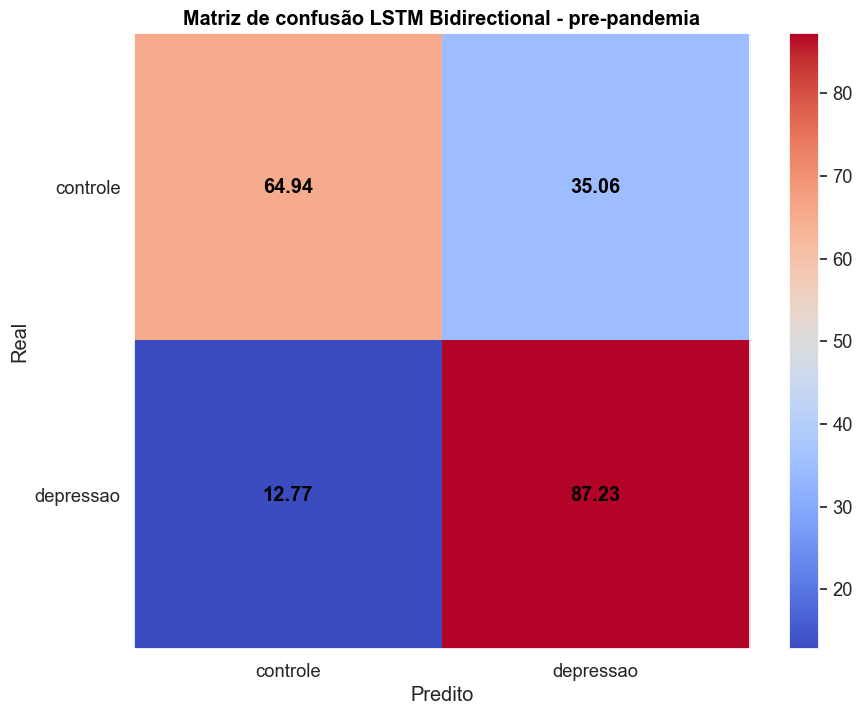

In [10]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc', f1score, precision_m, recall_m])
model.fit(x_train, y_train,  validation_data=(x_test, y_test),  epochs = epochs, batch_size = 128, shuffle=True, callbacks = [early_stop], verbose=1)
loss, acuracia, f1_score, precisao, revocacao = model.evaluate(x_test, y_test, verbose=0)

print()
print('LSTM Bidirectional')
imprimir_metricas(precisao, revocacao, f1_score, acuracia)
predicao = model.predict(x_test)
plotarMatrizConfusao(y_test, predicao, 'LSTM Bidirectional', label_encoder, periodo)

# Pandemia

In [11]:
periodo = 'pandemia'

choq = ['volumeTweets_media', 'volumeTweets_variancia', 'volumeTweets_mediaMovelPonterada', 'volumeTweets_entropia', 
'indiceInsonia_variancia', 'indiceInsonia_mediaMovelPonterada', 'indiceInsonia_entropia', 
'pronome1Pessoa_media', 'pronome1Pessoa_variancia', 'pronome1Pessoa_mediaMovelPonterada', 'pronome1Pessoa_entropia', 
'pronome2Pessoa_mediaMovelPonterada', 
'pronome3Pessoa_media', 'pronome3Pessoa_variancia', 'pronome3Pessoa_mediaMovelPonterada', 'pronome3Pessoa_entropia', 
'valencia_mediaMovelPonterada', 'valencia_entropia', 
'ativacao_mediaMovelPonterada', 'ativacao_entropia', 
'termosDepressivos_variancia', 
'grafoSocial_variancia', 'grafoSocial_mediaMovelPonterada', 'grafoSocial_entropia',
'medicamentosAntiDepressivo_mediaMovelPonterada'
]


atributos_anterioes = ['caracteresOrientais_variancia', 
'emojis_variancia', 
'midia_variancia', 'midia_mediaMovelPonterada', 
'curtidas_media', 'curtidas_variancia', 'curtidas_mediaMovelPonterada',
'links_mediaMovelPonterada'
]

atributos_novos = ['hashtags_variancia', 'hashtags_mediaMovelPonterada', 
'retweets_variancia', 
'mencoes_variancia', 'mencoes_mediaMovelPonterada', 
'polaridade_entropia', 
'subjetividade_entropia'
]

df = pd.read_csv(f'datasets/twitterbase_{periodo}.csv', sep=';')

cv = KFold(n_splits=10, shuffle=True, random_state=42)
zscore = StandardScaler()

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

label_encoder = LabelEncoder()
df['classe'] = label_encoder.fit_transform(df['classe']).astype('float64')

x = df.drop('classe', axis=1).copy()
y = df['classe'].copy()
x = zscore.fit_transform(x)

model = model_CNN_LSTM()

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_ratio, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_ratio, random_state=42)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

Epoch 1/20

398/398 [==============================] - 57s 136ms/step - loss: 0.6868 - acc: 0.5627 - f1score: 0.6009 - precision_m: 0.5736 - recall_m: 0.6454 - val_loss: 0.6614 - val_acc: 0.6134 - val_f1score: 0.6435 - val_precision_m: 0.6203 - val_recall_m: 0.6735
Epoch 2/20
398/398 [==============================] - 48s 119ms/step - loss: 0.6585 - acc: 0.6153 - f1score: 0.6500 - precision_m: 0.6201 - recall_m: 0.6908 - val_loss: 0.6423 - val_acc: 0.6472 - val_f1score: 0.6362 - val_precision_m: 0.6904 - val_recall_m: 0.5941
Epoch 3/20
398/398 [==============================] - 56s 140ms/step - loss: 0.6406 - acc: 0.6392 - f1score: 0.6600 - precision_m: 0.6508 - recall_m: 0.6777 - val_loss: 0.6248 - val_acc: 0.6546 - val_f1score: 0.6872 - val_precision_m: 0.6548 - val_recall_m: 0.7268
Epoch 4/20
398/398 [==============================] - 58s 146ms/step - loss: 0.6268 - acc: 0.6588 - f1score: 0.6737 - precision_m: 0.6736 - recall_m: 0.6825 - val_loss: 0.6188 - val_acc: 0.6658 - val_f1sc

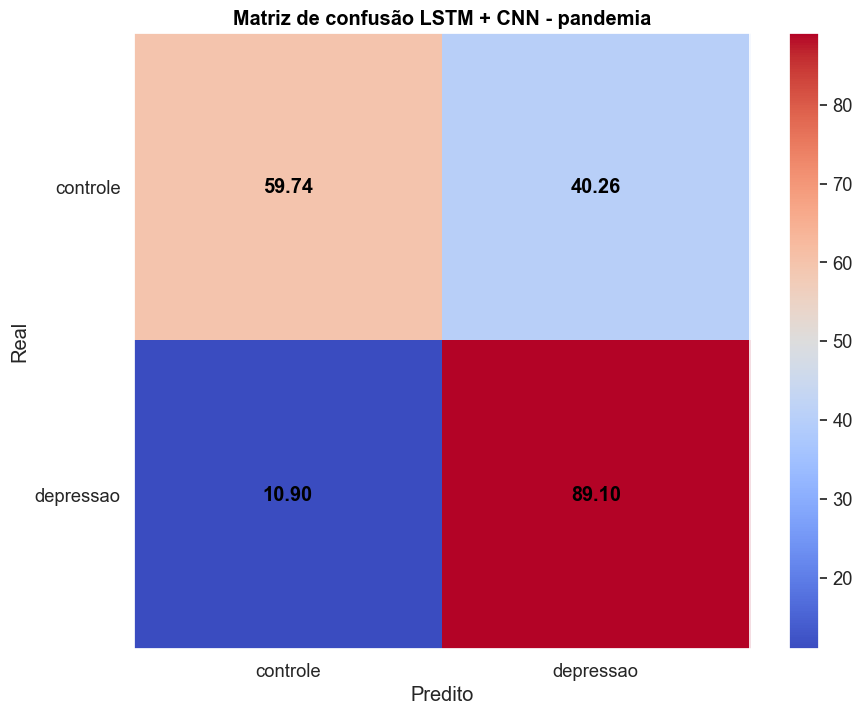

In [13]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc', f1score, precision_m, recall_m])
model.fit(x_train, y_train,  validation_data=(x_test, y_test),  epochs = epochs, batch_size = 128, shuffle=True, callbacks = [early_stop], verbose=1)
loss, acuracia, f1_score, precisao, revocacao = model.evaluate(x_test, y_test, verbose=0)

print()
print('LSTM + CNN')
imprimir_metricas(precisao, revocacao, f1_score, acuracia)
predicao = model.predict(x_test)
plotarMatrizConfusao(y_test, predicao, 'LSTM + CNN', label_encoder, periodo)